# Graph exploration & analysis

--------------

## Preliminaries

- ### Objective :

Predict the virality of memes/hashtags in a social network (Twitter).

- ### Context and motivations :

Virality is, in social networks, an important issue for corporations, political campaigns and influencers as they spend enormous resources and efforts to make their products or messages go viral in order to catch attention and spread their influence/activities to a wider audience.
Thus, understanding the complex mechanism of virality may help one control its effects over the network:
- How does the network structure affect the diffusion? 
- How to model the contagion, etc.

Proposal brought by the paper : the  broad idea is that network communities allow predict virality by its early spreading pattern. A simple, popular approach in studying hashtags diffusion is to consider hashtags as diseases and apply epidemic models. However, recent studies demonstrate that diseases and behaviors spread differently.
We can see huge potentiality for applications in social media marketing : social networks could give better advice to their users as to which posts are likely to give best advertising Return on Investment.


- ### Imports

In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from itertools import product
from itertools import permutations, combinations
%matplotlib inline

## I. Data exploration

**** CITATION ****
Please cite our paper as follows, when you are using our dataset:
Lilian Weng, Filippo Menczer, and Yong-Yeol Ahn. Virality Prediction and Community Structure in Social Networks. Nature Scientific Report. (3)2522, 2013.



**** DATA SOURCE ****
Sampled public tweets from Twitter streaming API (https://dev.twitter.com/docs/streaming-apis).
Date range: March 24, 2012 to April 25, 2012.



**** NETWORKS ****
follower_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID
    Anonymized reciprocal follower network.
    Each edge is a pair of Twitter user who are following each other. After recovering the reciprocal follower network, the giant connected component is extracted.

retweet_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID weight
    Anonymized reciprocal retweet network.
    Similarly to follower_gcc.anony.dat, but instead each edge is a pair of users who retweeted each other at least once during our observation time window. Weight is the sum of how many times user1 retweeted user2 or user2 retweeted user1.

mention_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID weight
    Anonymized reciprocal retweet network.
    Similarly to follower_gcc.anony.dat, but instead each edge is a pair of users who mentioned each other at least once during our observation time window. Weight is the sum of how many times user1 mentioned user2 or user2 mentioned user1.



**** HASHTAG SEQUENCES ****
timeline_tag.anony.dat
    Format: hashtag timestamp1,anony.user1.id timestamp2,anony.user2.id ...
    Each line is a hashtag followed by the sequence of its adopters sorted by timestamp. A user is considered as an adopter of a hashtag once he/she starts using the hashtag. We only consider users who appear in the collected networks. The timestamp is the time when we see the hashtag in the user's tweets. The file includes both emergent hashtags and non-emergent ones.

timeline_tag_rt.anony.dat
    Format: hashtag timestamp1,anony.retweet_user1.id,anony.retweet_from_user1.id timestamp2,anony.retweet_user2.id,anony.tweet_from_user2.id ...
    Each line is a hashtag followed by the sequence of its adopters retweeting about this hashtag from other users sorted by timestamp. A "retweet_user" retweets a message containing the hashtag from a "retweet_from_user". We only consider users who appear in the collected networks. The file includes both emergent hashtags and non-emergent ones.

timeline_tag_men.anony.dat
    Format: hashtag timestamp1,anony.mention_user1.id,anony.mentioned_user1.id timestamp2,anony.mention_user2.id,anony.mentioned_user2.id ...
    Each line is a hashtag followed by the sequence of its adopters mentioning other users in messages containing this hashtags sorted by timestamp. A "mention_user" mentions a "mentioned_user" in a message with the target hashtag. We only consider users who appear in the collected networks. The file includes both emergent hashtags and non-emergent ones.



** Note that users in these networks and timeline sequencies are anonymized in the same way so that the same IDs refer to the same Twitter users.**

In [2]:
#load from raw dat file into dataframes
    #for relationships graphs
df1 = pd.read_csv('../../../virality2013/follower_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2"])
#df2 = pd.read_csv('../../../virality2013/mention_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2","weight"])
#df3 = pd.read_csv('../../../virality2013/retweet_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2","weight"])
    
    #for hashtags spreading, the data format is too large to compute as matrix (over billion units)
#df4 = pd.read_csv('../../../virality2013/timeline_tag.anony.dat',sep=' ',header=None,names=header_tl)
#df5 = pd.read_csv('../../../virality2013/timeline_tag_men.anony.dat',sep=' ',header=None,names=header_tl_men)
#df6 = pd.read_csv('../../../virality2013/timeline_tag_rt.anony.dat',sep=' ',header=None,names=header_tl_rt)

- ### Hashtags analysis

In [3]:
ht=[]
l=[]
n=0
with open('../../../virality2013/timeline_tag.anony.dat',"r") as f:
    for line in f:
        hashtag = line.split(" ")[0]
        size = len(line.split(" "))
        ht.append(hashtag)
        l.append(size)
ht_df=pd.DataFrame()
ht_df['hashtag']=ht
ht_df['count_adopters']=l

print("Max len for a row : %s" %max(l))
print("Nb of hashtags : %s" %(len(ht)))

Max len for a row : 363519
Nb of hashtags : 1345913


In [4]:
ht_df = ht_df[ht_df['hashtag'].str.len() > 3] #filter meaningless hashtags
ht_df.sort(columns='count_adopters',ascending=False,inplace=True)
ht_df.reset_index(inplace=True,drop=True)

/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


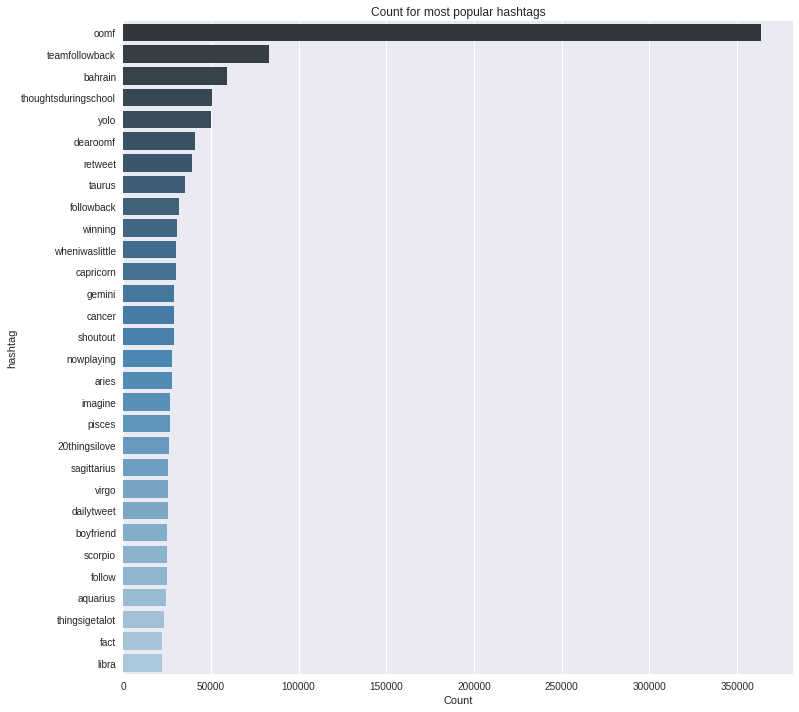

In [5]:
ht_df_ = ht_df[0:30]
plt.figure(figsize=(12,12))
a=sns.barplot(y=ht_df_['hashtag'],x=ht_df_['count_adopters'],palette="Blues_d")
a.set_title('Count for most popular hashtags')
a.set_xlabel('Count')

- ### Light Network Analysis:

In [6]:
%%time
g1 = nx.from_pandas_dataframe(df1,source="user_1",target="user_2") #.to_undirected()
del df1 #supress to free memory
g1 = g1.to_undirected()

CPU times: user 2min 59s, sys: 4.66 s, total: 3min 4s
Wall time: 3min 3s


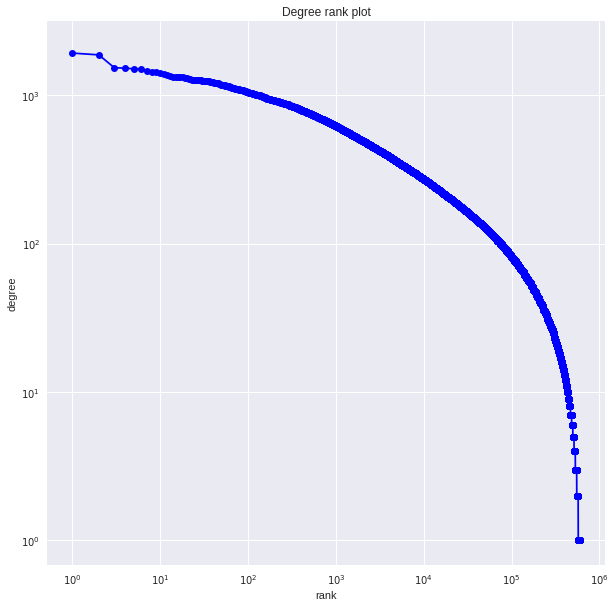

CPU times: user 9 s, sys: 64 ms, total: 9.07 s
Wall time: 9.04 s


In [7]:
%%time
degree_sequence=sorted(nx.degree(g1).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

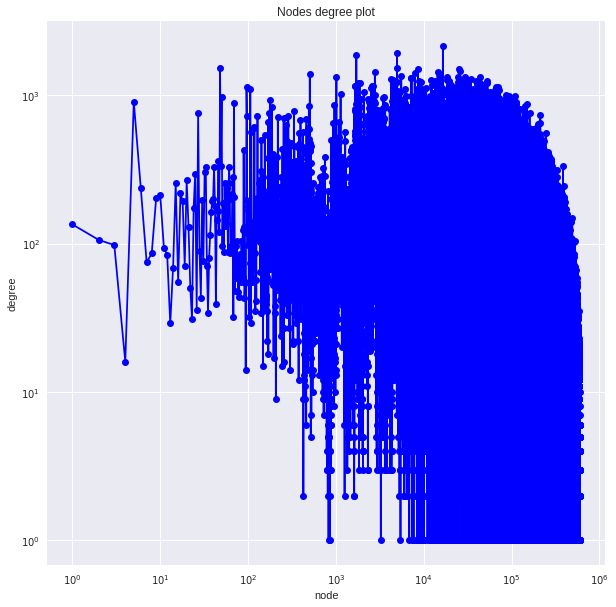

CPU times: user 9.66 s, sys: 20 ms, total: 9.68 s
Wall time: 9.63 s


In [8]:
%%time
degree_sequence=nx.degree(g1).values()
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Nodes degree plot")
plt.ylabel("degree")
plt.xlabel("node")

plt.show()

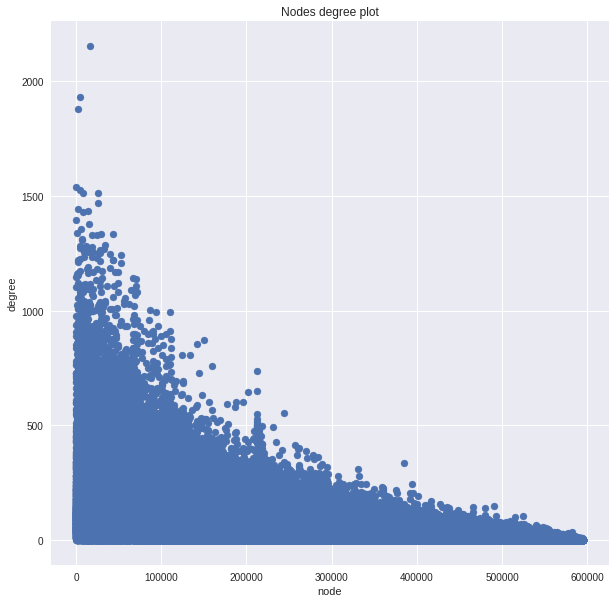

CPU times: user 20.9 s, sys: 108 ms, total: 21.1 s
Wall time: 21 s


In [9]:
%%time
degree_sequence=nx.degree(g1).values()
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.figure(figsize=(10,10))
plt.scatter(nx.degree(g1).keys(),degree_sequence)
plt.title("Nodes degree plot")
plt.ylabel("degree")
plt.xlabel("node")

plt.show()

## II. Sampling

- ### Random node sampling: 

In [10]:
def sample_nodes(node_list,ratio):
    nb_sample = ratio*len(node_list)
    nb_sample = int(nb_sample)
    sample = np.random.choice(np.array(node_list),size=nb_sample)
    return sample

def get_nodes(g):
    node_list = list(g.nodes())
    return node_list

def induced_graphed(vertex,g):
    return 

In [11]:
%%time
nodes1 = get_nodes(g1)
sample = sample_nodes(nodes1,0.01)

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 39.8 ms


- ### Degree distribution sampling

## III. Hashtags community:

In [12]:
def extract_from_hash(hashtag,file_path,extended=True):
    mat = []    
    if extended == True:
        with open(file_path,"r") as f:
            for line in f:
                if hashtag in line:
                    mat.append(line.split(" "))
        pading =    max([len(x) for x in mat])      
        mat = np.array([np.array(pad(x,pading)) for x in mat])
        return pd.DataFrame(mat)
    else:
        with open(file_path,"r") as f:
            for line in f:
                if hashtag == line.split(" ")[0]:
                    mat.append(line.split(" "))
                    break
        pading =    max([len(x) for x in mat])      
        mat = np.array([np.array(pad(x,pading)) for x in mat])
        return pd.DataFrame(mat)

def pad(list_,length):
    return list_[:length] + [np.nan]*(length-len(list_))

def find_infected_vertex(df):
    keep=[]
    for col in df.columns[1:]:
        array=split_clean(df[col])
        keep.append([x[1] for x in array if isinstance(x,list)])
    return list(set([val for sublist in keep for val in sublist]))

def fin_infected_timeline(df):
    keep=[]
    for col in df.columns[1:]:
        array=split_clean(df[col])
        keep.append([x[0] for x in array if isinstance(x,list)])
    return list(set([val for sublist in keep for val in sublist]))


def split_clean(list_):
    array= [ x.split(",") for x in list_]
    array= [ np.nan if x[0]=='nan' else [int(x[0]),int(x[1].strip('\n'))] for x in array ]
    return array

def query_from_vertices(df,liste_):
    df=df[(df['user_1'].isin(liste_)) | (df["user_2"].isin(liste_))]
    return df

In [13]:
ht_df[ht_df["count_adopters"]<=450]

,hashtag,count_adopters
2401,southside,450
2402,newyork,450
2403,dandh,449
2404,greysonfact,449
2405,likehonestly,448
2406,whoa,448
2407,sticksandstonestour2012,448
2408,whatthefuck,448
2409,alfateh,448
2410,theq,448


In [14]:
ht_df[ht_df["hashtag"]=="thoughtsduringschool"]

,hashtag,count_adopters
3,thoughtsduringschool,50928


In [15]:
ht_df[ht_df["hashtag"]=="madonna"]

,hashtag,count_adopters
3552,madonna,300


In [16]:
%%time
#guncontrol teamunicorns genocide  ThoughtsDuringSchool madonna
hashtag='madonna'
df = extract_from_hash(hashtag,"../../../virality2013/timeline_tag.anony.dat",extended = False)
t=find_infected_vertex(df)
t_timeline = fin_infected_timeline(df)
print("There are %s infected nodes for the hashtags %s" %(len(t),hashtag))

There are 159 infected nodes for the hashtags madonna
CPU times: user 416 ms, sys: 20 ms, total: 436 ms
Wall time: 436 ms


In [17]:
#evaluate quantity over time
#work in progress
#len(t)==len(t_timeline)

In [18]:
def compute_shortest(couple):
    if couple[0] not in master_nodes or couple[1] not in master_nodes:
        return None
    else:
        try:
            nodes=nx.shortest_path(g1,source=couple[0],target=couple[1])
        except Exception as e:
            print('Failed at stage %s %s for reason : %s' %(couple[0],couple[1],e))
            nodes=None
        return nodes
    
def compute_shortest_speed(couple):
    #without if control, loop is 10x faster
    try:
        nodes=nx.shortest_path(g1,source=couple[0],target=couple[1])
    except Exception as e:
        #print('Failed at stage %s %s for reason : %s' %(couple[0],couple[1],e))
        nodes=None
    return nodes

In [19]:
%%time
#combination multiprocessed
#multiprocessing alternatives
import multiprocessing as mp
import datetime


master_nodes=g1.nodes()
combi = list(combinations(t,2))
print(len(combi))

try:
    pool = mp.Pool(processes=8)
    start_time=datetime.datetime.now()
    nodes_ = pool.map(compute_shortest_speed,combi)
    pool.close()
    pool.join()
    elapsed=datetime.datetime.now()-start_time
    print("Done processing in %s" %(elapsed))
except Exception as e:
    print(e)
    pool.close()
    pool.join()
    print('Pool successfuly closed!')


#purge
del combi
del master_nodes

12561
Done processing in 0:00:02.698825
CPU times: user 56 ms, sys: 772 ms, total: 828 ms
Wall time: 3.48 s


In [20]:
#filter none
nodes_ = [x  for x in nodes_ if x]

In [21]:
def to_flat(liste_):
    flat=[]
    for element in liste_:
        try:
            flat.append([x for x in element])
        except Exception as e:
            print(e)
    return flat

In [22]:
%%time
#nodes_=np.array(flat).flatten()
flat=[val for sublist in nodes_ for val in sublist]
print(len(flat))
#flat_=[val for sublist in flat_ for val in sublist]

56689
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.73 ms


In [23]:
#flat = sample_nodes(flat,1)
h=g1.subgraph(flat)
len(h.nodes())

5530

/home/paul/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/paul/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/paul/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/paul/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprec

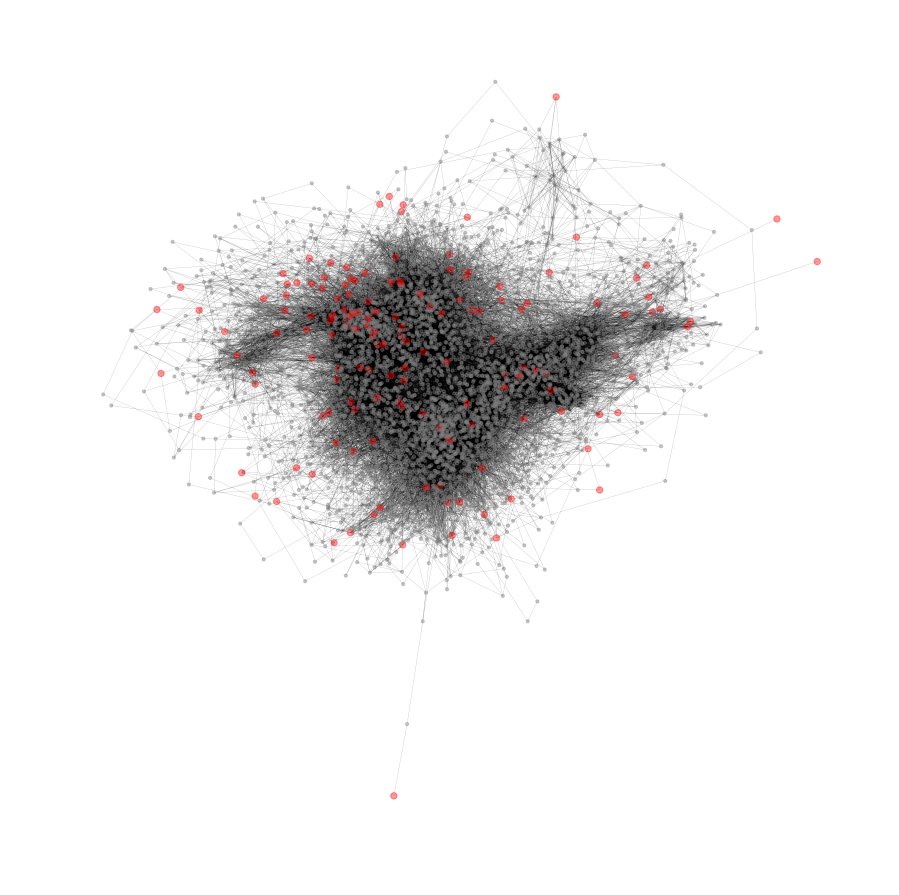

CPU times: user 1min 35s, sys: 188 ms, total: 1min 35s
Wall time: 1min 35s


In [24]:
%%time

color_map=[]
size = []
for node in h:
    if node in t:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('grey')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(h, **options_3)
plt.savefig("%s_shortest_path.png" %(hashtag), dpi=300)
plt.show()

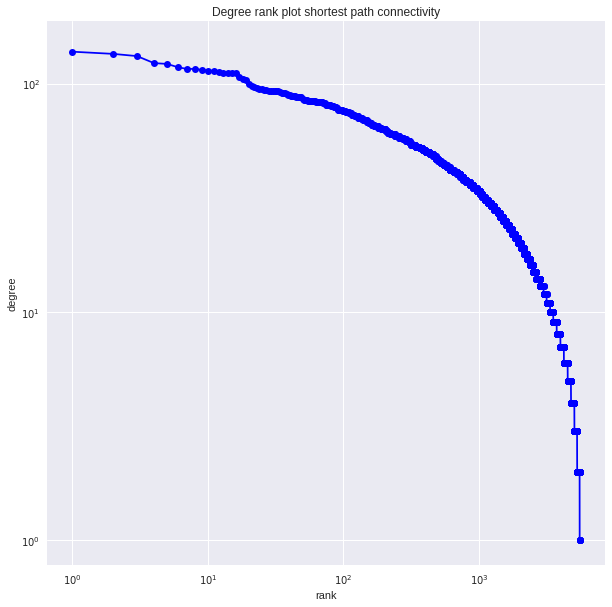

In [25]:
degree_sequence=sorted(nx.degree(h).values(),reverse=True) # degree sequence

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot shortest path connectivity")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

In [26]:
%%time
#add old
df1 = pd.read_csv('../../../virality2013/follower_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2"])
df1=query_from_vertices(df1,t)

h_=nx.from_pandas_dataframe(df1,source="user_1",target="user_2") #.to_undirected()
del df1 #supress to free memory
h_ = h_.to_undirected()


#compose
composed = nx.compose(h,h_)

CPU times: user 5.74 s, sys: 192 ms, total: 5.94 s
Wall time: 5.94 s


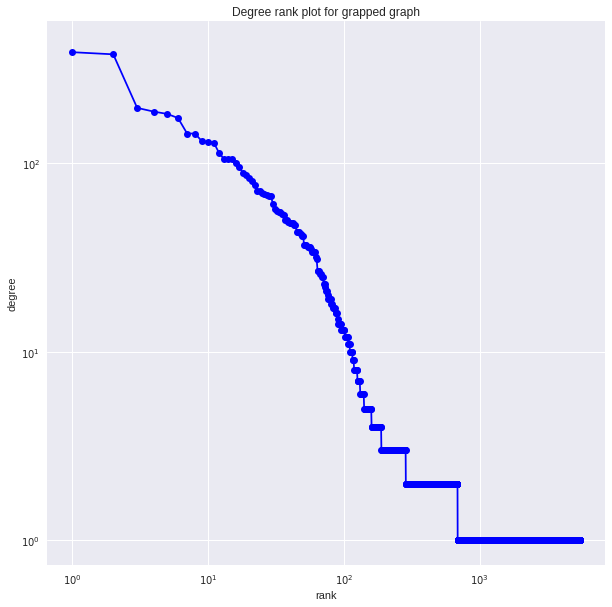

In [27]:
degree_sequence=sorted(nx.degree(h_).values(),reverse=True) # degree sequence

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot for grapped graph")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

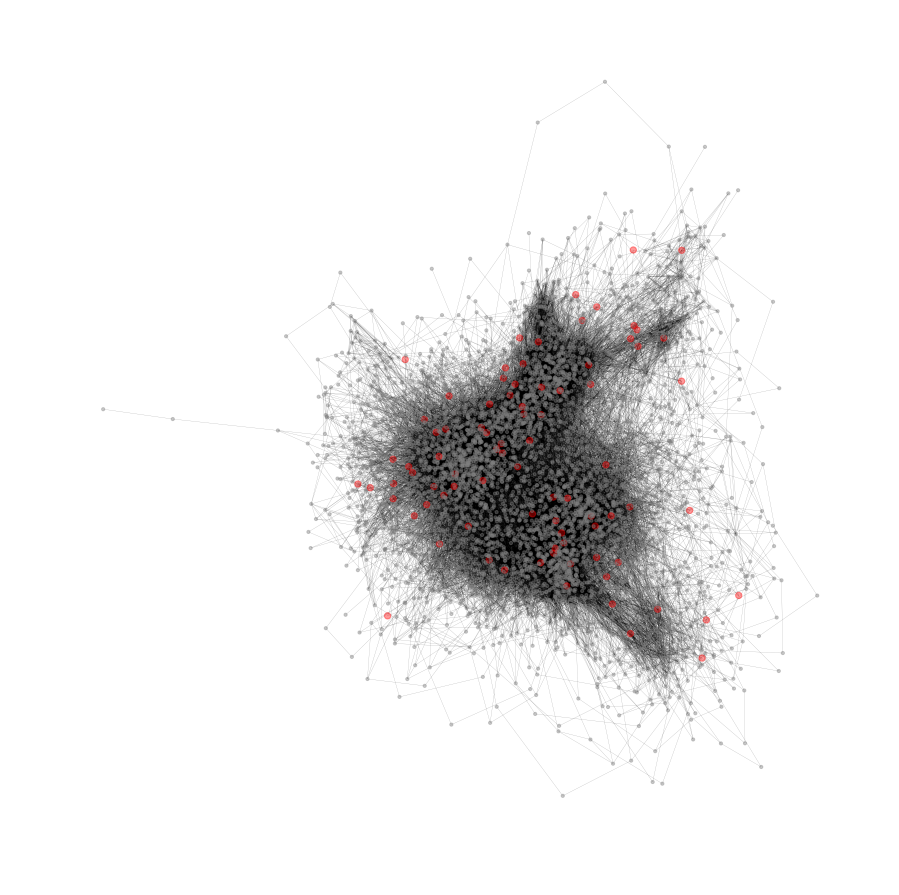

CPU times: user 1min 37s, sys: 4 ms, total: 1min 37s
Wall time: 1min 37s


In [28]:
%%time

color_map=[]
size = []
for node in composed:
    if node in t:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('grey')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(h, **options_3)
plt.savefig("output_pictures/%s_composed.png" %(hashtag), dpi=300)
plt.show()

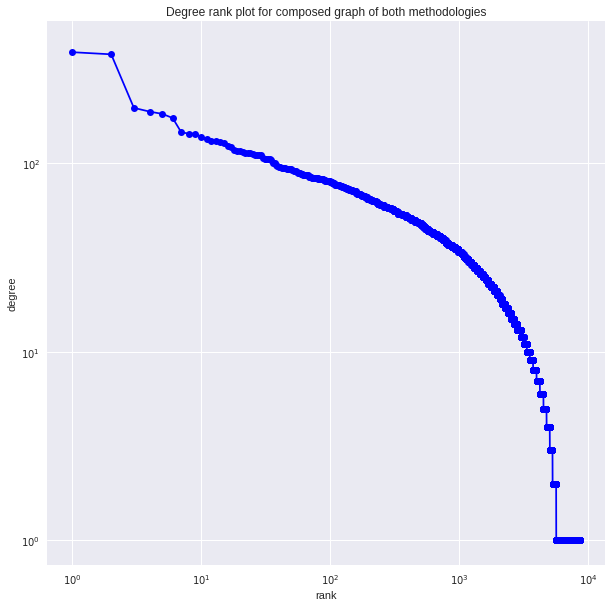

In [29]:
degree_sequence=sorted(nx.degree(composed).values(),reverse=True) # degree sequence

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot for composed graph of both methodologies")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

## IV. Extracting graph features:

In this section, we create all the features used to assess the virality of a given graph in the paper.

- #### Network features

In [30]:
#Number of early adopters : is the set of distinct adopters in the earliest n tweets of a meme h.
#For n=50
def get_early_adopters(n, df):
    user = []
    for col in df.columns[1:(n+1)]:
        array=split_clean(df[col])
        user.append(array[0][1])
    return user

early_adopters = get_early_adopters(50, df)
print(len(set(early_adopters)), "early adopters")

(40, 'early adopters')


In [31]:
#Size of first surface
#The second surface includes uninfected users in the second surface of early adopters,
#characterizing the number of potential adopters within two steps
def get_surface(df,liste_):
    df=df[(df['user_1'].isin(liste_)) | (df["user_2"].isin(liste_))]
    df=np.unique(df)
    df = [x for x in df if x not in liste_] #on supprime les nodes infectés
    return df
first_surface = get_surface(df1, early_adopters)
print(len(first_surface), "size of first surface")

NameError: name 'df1' is not defined

In [ ]:
#Size of second surface
#The first surface contains all the uninfected neighbors of early adopters of h.
second_surface = get_surface(df1, first_surface)
print(len(second_surface), "size of first surface")

- #### Distance features

In [ ]:
#Average step distance
if nx.is_connected(h):
    average_step_distance = nx.average_shortest_path_length(h)
else:
    average_step_distance=[]
    for g in nx.connected_component_subgraphs(h):
        average_step_distance.append(nx.average_shortest_path_length(g))
average_step_distance

- #### Community features